# Isomap
This is the third part in *Manifold Learning: Introduction and Foundational Algorithms*, and the entire project can be viewed at https://github.com/drewwilimitis/Manifold-Learning <br>
<br>
`Drew Wilimitis`

**Isomap** 等距映射）是非线性降维和流形学习中的另一个基础算法。Isomap引入了一种独特的学习全局几何结构的方法，该方法基于使用最近邻图表示高维数据集。其思想是沿着图的边行进的距离近似于沿着流形的距离。 <br>
<br>
通过学习沿着流形定义的内在度量而不是由外部坐标系定义的度量，Isomap可以学习高度复杂、非线性的几何关系。此外，Isomap提供了一个保留高维结构的低维嵌入变换。

在深入介绍算法的细节之前，我们定义了两个重要的概念。给定具有度量$d_x$和$d_y$的两个度量空间$X$和$Y$，**等距同构(Isometry)** 是两个度量空间之间保持距离的双射映射$f : X \rightarrow Y$：

$$
d_{Y}(f(a), f(b))=d_{X}(a, b)
$$

在我们的情况下，我们希望从流形中找到一个*等距*映射，其中数据点$x_i$和$x_j$沿着流形的距离（作为图的**测地线**距离）等于相应的低维输出向量$y_i$和$y_j$之间的欧几里德距离。


![title](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Spherical_triangle.svg/225px-Spherical_triangle.svg.png)
A triangle formed on the surface of a sphere by the geodesic lengths between points A, B, C. Source: https://en.wikipedia.org/wiki/Geodesic

对于任何一般的表面，**测地线(geodesic)** 是一条局部长度最小化的路径。测地线将直线最短路径（在欧几里得平面上）推广到内在定义的表面几何。在isomap算法中，我们通过**图测地线**来近似流形表面上的最短路径 - 即两个节点之间的最小加权路径。 

### 算法概述（Isomap）：
**输入：** 具有参数 k（最近邻）和 m（嵌入维度）的数据向量 $\mathbf{x_1}, ..., \mathbf{x_n} \in \mathbb{R^d}$ <br>
**输出：** 较低维度的嵌入向量 $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$，其中 $m < d$
<br>
**步骤**：<br>
1. 找到每个点的 k 个最近邻，并创建最近邻图 $G$，其中数据点 $x_i$ 作为节点，并连接最近邻的边。<br>
2. 计算测地相似度矩阵 $D$，其中包含图中节点间的成对最短路径距离（Dijkstra 算法）<br>
3. 对矩阵 $D$ 应用多维缩放以形成较低维度的嵌入

### Step 1. kNN graph 

在计算欧几里得空间中的成对距离后，我们找到每个数据点的 k 个最近邻（可以使用 $\epsilon$-ball 方法，仅包括在某个 $\epsilon$ 半径内的邻居，或者只包括 k 个最近的欧几里得距离）。

接下来，定义图 $$G = ({V, E)}$$ <br>
让每个数据点 $x_i$ 成为节点 $v \in V$，具有边 $e_{i,j}$ 连接每对 $x_i$、$x_j$。对于给定的数据点 $x_i$、$x_j$，通过以下方式定义相应的边权重：<br>
<br>
$$
\ w_{i,j} = \begin{cases} 
      d(x_i,x_j) & x_j \ \text{是 $x_i$ 的最近邻} \\
      \infty & 否则 \\ 
   \end{cases}
\\ $$ <br>
这实际上只连接了最近邻的边，因为除此之外，边的权重设置为 $\infty$，表示它们之间的图距离为无限远。但我们这样做是为了使 kNN 图连接，并确保它满足我们使用的图算法的条件。

### <font color='blue'> Example - More on Geodesics and the kNN Graph</font> 

Here we show a 2D example illustrating a kNN graph and we compare geodesic vs. Euclidean distances. 

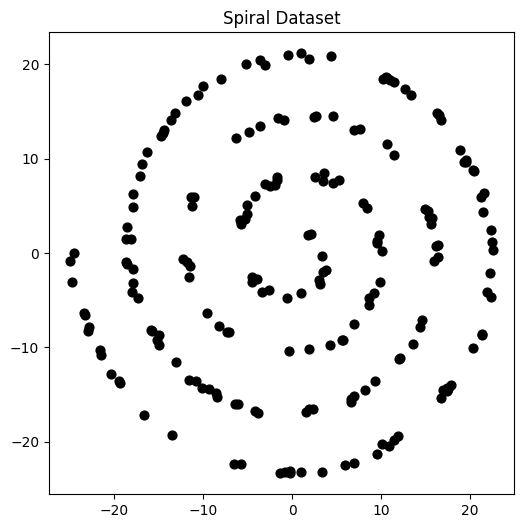

In [1]:
import numpy as np  # 导入NumPy库
import matplotlib.pyplot as plt  # 导入Matplotlib库
import seaborn as sns  # 导入Seaborn库
%matplotlib inline  
plt.figure(figsize=(6,6))  # 创建一个图表，设置尺寸为6x6
# 在单元格中显示多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.random.seed(8888)  # 设置随机种子

# 生成螺旋数据集
n = np.sqrt(np.random.rand(200,1)) * 1440 * (2*np.pi)/360
d1x = -np.cos(n)*n + np.random.rand(200,1) * 0.8
d1y = np.sin(n)*n + np.random.rand(200,1) * 0.8

plt.scatter(d1x, d1y, c='black', s=40)  # 绘制散点图
plt.title('Spiral Dataset')  # 设置图表标题
X = np.hstack((d1x,d1y));  # 将数据组合成特征矩阵

这是一个非常简单的非线性流形。这里的数据大致沿着 $\mathbb{R^2}$ 中的嵌入曲线分布，并在局部看起来是线性的。现在我们找到 k 个最近邻，并在图上连接它们之间的边。请注意，我们通过原始空间中的欧氏距离找到这些最初的最近邻

In [2]:
# 计算成对距离矩阵以找到数据集 X 中每个 x_i 的 k 个最近邻的函数
"""
计算数据集中每个数据点之间的成对欧氏距离。
参数：
    X : numpy.ndarray
     形状为 (n_samples, n_features) 的数据集。
返回：
    dist_matrix : numpy.ndarray
     形状为 (n_samples, n_samples) 的距离矩阵，其中 dist_matrix[i, j] 是 X[i] 和 X[j] 之间的欧氏距离。
"""
def pairwise_distances(X):
    n_samples = X.shape[0] # 获取样本数量：即获取数据集 X 的行数
    dist_matrix = np.zeros((n_samples, n_samples))  # 初始化距离矩阵为零矩阵
    for i in range(n_samples):  # 计算第 i 和第 j 个样本之间的欧氏距离
        for j in range(n_samples):
            dist_matrix[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))
    return dist_matrix

# 一个能够为 X 中每个值输出 N x k 矩阵的函数，其中每个值有 k 个最近邻
def nearest_neighbors(X, k):
    knn_matrix = np.zeros((len(X), k))  # 创建一个N x k的零矩阵，用于存储每个观察值的k个最近邻
    dist_matrix = pairwise_distances(X)  # 重新计算成对距离
    for i in range(len(X)):
        # 对每一行找到k个最近邻的索引
        knn_matrix[i] = dist_matrix[i, :].argsort()[1:k + 1]
    return knn_matrix  # 返回最近邻矩阵

'\n计算数据集中每个数据点之间的成对欧氏距离。\n参数：\n    X : numpy.ndarray\n     形状为 (n_samples, n_features) 的数据集。\n返回：\n    dist_matrix : numpy.ndarray\n     形状为 (n_samples, n_samples) 的距离矩阵，其中 dist_matrix[i, j] 是 X[i] 和 X[j] 之间的欧氏距离。\n'

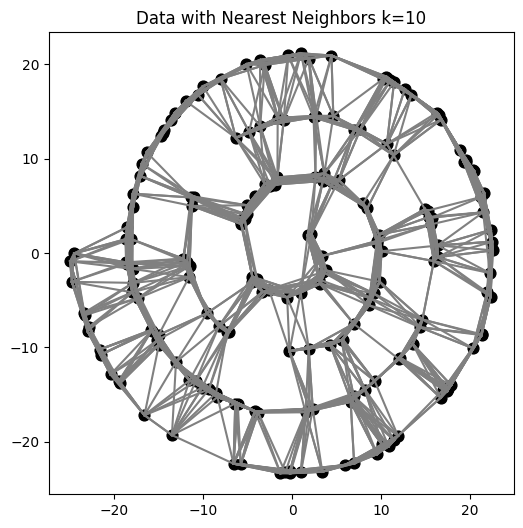

In [3]:
k = 10  # 设置最近邻数量
# 寻找每个数据点的最近邻
X_neighbors = nearest_neighbors(X, k)

# 遍历每个数据点并连接到其最近邻
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=0.3, c='black', s=50)  # 绘制散点图
for i in range(len(X)):
    neighbors = X_neighbors[i]
    for j in range(len(neighbors)):
        # 绘制每个数据点到其最近邻的连线
        plt.plot(X[[i, neighbors.astype('int')[j]], 0], X[[i, neighbors.astype('int')[j]], 1], c='gray')

plt.title('Data with Nearest Neighbors k=' + str(k))  # 设置图标题
plt.scatter(X[:,0], X[:,1], c='black', s=60)  # 重新绘制散点图，突出数据点
plt.show();  # 显示图形

Now let's look at one region to see how the geodesic distances might better describe the manifold structure than Euclidean distances.

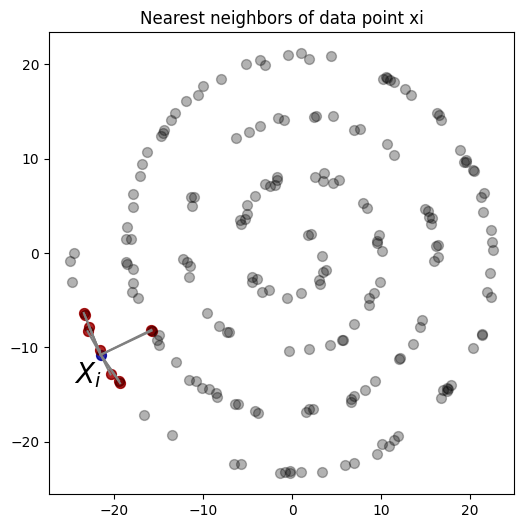

In [4]:
# 获取给定xi（X中的第一个元素）的最近邻
neighbors = X_neighbors[0]  # 最近邻的索引
plt.figure(figsize=(6,6))
# 绘制xi点（蓝色）
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)
plt.text(X[0, 0]-3, X[0, 1] - 3, s='$X_i$', size=20)  # 在xi点附近添加标签

# 绘制最近邻点（红色）
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha=0.8, s=50)

# 绘制xi点与其最近邻之间的连线（灰色）
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')

# 绘制所有数据点（黑色）
plt.scatter(X[:,0], X[:,1], alpha=0.3, c='black', s=50)

plt.title('Nearest neighbors of data point xi')  # 设置图标题
plt.show();  # 显示图形

In [5]:
# 获取 xi 最近邻的坐标
xi_nn = []

# 循环遍历 xi 的最近邻索引
for i in range(len(neighbors)):
    # 将每个最近邻的坐标添加到 xi_nn 列表中
    xi_nn.append(X[neighbors.astype('int')[i]])
# 将 xi_nn 转换为 NumPy 数组
xi_nn = np.array(xi_nn)

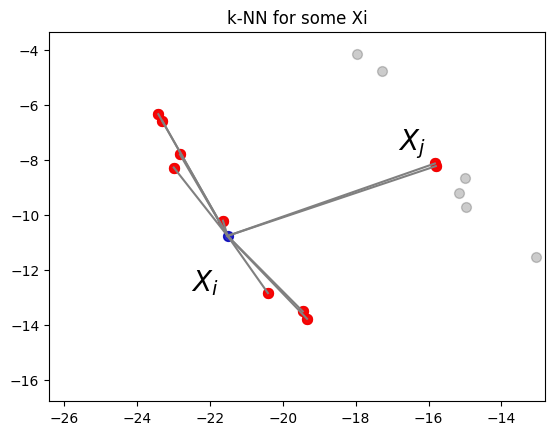

In [6]:
# 放大 xi 并绘制最近邻边缘
j = k - 1  # j 是 xi 的最后一个最近邻的索引

# 绘制 xi 和最近邻 j 的散点图
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)  # xi 的蓝色点
plt.text(X[0, 0] - 1, X[0, 1] - 2, s='$X_i$', size=20)  # 标记 xi
plt.text(xi_nn[j][0] - 1.0, xi_nn[j][1] + 0.5, s='$X_j$', size=20)  # 标记最近邻 j

# 绘制 xi 的最近邻为红色的散点图
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha=0.8, s=50)

# 绘制每个最近邻的边缘线
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')

# 绘制所有数据点的散点图（半透明）
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);

# 再次绘制最近邻点（红色）
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha=0.8, s=50)

# 设置图标题
plt.title('k-NN for some Xi')

# 设置 x 和 y 轴的范围，以放大图像
plt.xlim(np.min(xi_nn[:,0])-3, np.max(xi_nn[:,0])+3)
plt.ylim(np.min(xi_nn[:,1])-3, np.max(xi_nn[:,1])+3);

在这种情况下，欧氏距离给出的最近邻不一定是沿着流形的最近邻。在二维欧氏空间中，$x_i$ 和 $x_j$ 距离较近，但是如果考虑只能沿着螺旋环流形移动，那么 $x_j$ 将会比许多其他可能的 $x_i$ 的候选邻居更远。<br>
<br>
使用 Isomap 的测地线距离有助于揭示这种流形结构，而不是仅使用欧氏距离（比如 MDS）。欧氏距离经常会因为这种“短路”问题而失败，即在更大的外部空间中点可能很接近，但在非线性流形上却相距甚远。<br>
<br>
此外，在这里尝试不同的 k 值可以改善 Isomap 的性能，因为它不允许在外部欧氏空间中发生太多的“跳跃”。

## Step 2. Shortest Path Algorithms and Pairwise Graph Geodesics

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Shortest_path_with_direct_weights.svg/375px-Shortest_path_with_direct_weights.svg.png)

The shortest path from A to F in this figure is given by the path A-C-E-D-F. Source: https://en.wikipedia.org/wiki/Shortest_path_problem

虽然这张图展示了一个有向图，而我们的最近邻图将是无向的，但这个图示说明了如何计算图上的距离和最短路径地理曲线。从节点 A 到节点 B 的最短路径是使路径上的边的加权和最小化的路径。

We have two prominent algorithms for finding the shortest or minimum weight path between two nodes in a graph: <br>
- Dijkstra's Algorithm <br>
- The Floyd-Warshall Algorithm

I won't go into their implementations too extensively, but the important point is that these algorithms compute pairwise geodesic distances between our data points, which the final input used to find our lower dimensional embedding.

Floyd's Algorithm 
------------------------------------------------------
弗洛伊德算法计算图中所有点对之间的测地距离。其时间复杂度为 $\mathcal O(n^3)$，而 Dijkstra 算法的时间复杂度为 $\mathcal O(n^2\log(n))$。

弗洛伊德算法的思想是通过迭代地设置测地距离： <br>

对于已定义了边权重的相邻点，设 $D_{i,j}$ = $d(x_i, x_j)$ <br>
否则，通过中间边进行搜索，迭代地寻找最短路径，直至得到计算得到的测地距离
弗洛伊德算法通过以下更新规则迭代 k，其中 $k=1,\dots,n$

$D(i,j) \leftarrow \min(D(i,j), \underbrace{D(i,k)+D(k,j)}_{\text{中间边}})$

Dijkstra's Algorithm
------------------------------------------------------

Dijkstra 算法比较难以简洁地解释。它是一种深度优先搜索算法，用于查找源节点和目标节点之间的最短路径。它也是一种迭代过程，它跟踪具有最低权重的未访问节点，并尝试通过这些未访问节点找到更好的中间路径，同时在进行时更新从源节点出发的距离。

There's plenty of great resources explaining Dijkstra's algorithm for more details on its implementation and computational complexity, but I provide some pseudocode and an explanation from wikipedia here https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm:

1. 将所有节点标记为未访问状态。创建一个名为未访问集的未访问节点集合。
2. 为每个节点分配一个临时距离值：将初始节点设置为零，将所有其他节点设置为无穷大。将初始节点设置为当前节点。
3. 对于当前节点，考虑其所有未访问的邻居，并通过当前节点计算它们的临时距离。比较新计算的临时距离与当前分配的值，并分配较小的值。例如，如果当前节点 A 的距离标记为 6，并且与其相邻的节点 B 的边长为 2，则通过节点 A 到达节点 B 的距离将为 6 + 2 = 8。如果节点 B 先前的距离大于 8，则将其更改为 8。否则，保留当前值。
4. 当我们考虑当前节点的所有未访问邻居时，将当前节点标记为已访问，并从未访问集中移除。已访问的节点将不会再次被检查。
5. 如果目标节点已被标记为已访问（在规划两个特定节点之间的路径时）或者未访问集中节点的最小临时距离为无穷大（在规划完整遍历时；当初始节点与剩余未访问节点之间没有连接时发生），则停止。算法已经完成。
6. 否则，选择标记有最小临时距离的未访问节点，将其设置为新的“当前节点”，并返回步骤 3。

Pseudocode for Dijkstra's Algorithm:

![title](https://raw.githubusercontent.com/drewwilimitis/Manifold-Learning/master/images/code.PNG)

Dijkstra's 算法最常用于 Isomap 的实现，并返回一个对称的、非负的距离矩阵，其中包含沿着图的节点之间的最短路径距离。然后可以将这个距离矩阵作为先前讨论的算法 - 多维尺度分析的输入。

## Step 3. Applying Multidimensional Scaling

现在我们有了成对的测地距离矩阵 D，可以将其输入到 MDS 中。我们使用平方测地距离 $D^{2}$ 来计算 Gram 矩阵 $B$：

$$\boxed {B = \frac{-1}{2} C_n D^{2} C_{n}^T}$$

**注：** $C_{n}$ = 居中矩阵，$D^{2}$ = 具有条目 ${d_{ij}^2}$ 的矩阵

现在我们可以使用 B 的特征分解：

$$B = Y Y^T = V \Lambda V^T$$

由于 $B$ 是对称的、正定的 $n \times n$ 矩阵，我们有：

$$ \boxed{Y = \Lambda^\frac{1}{2} V^T}$$

我们可以将维度降至 $m \leq d$：

$$ \boxed{Y_{m} = \Lambda_{m}^\frac{1}{2} V_{m}^T}$$

通过选择特征向量矩阵 V 的前 m 列，其中 $\Lambda_{m}$ 是由 m 个最大特征值组成的 m x m 对角子矩阵。

我们得到了我们的低维输出向量 $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$。我们使用了knn图来计算测地距离，并应用了MDS来保留这些测地距离，这样我们就保留了流形结构的信息，同时降低了维度。

### <font color='blue'> Example - Graph Geodesics on the Swiss Roll</font>

We now show an example of this k-NN graph and the graph geodesic distances on our favorite dataset for manifold learning: the swiss roll.

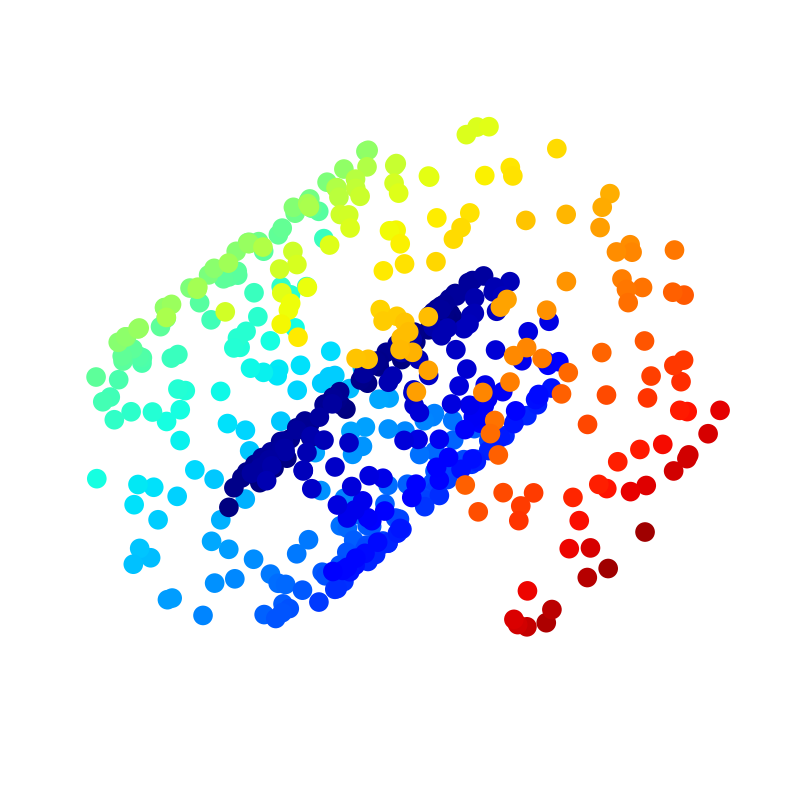

In [7]:
# generate data
n = 500
x = np.random.rand(2,n)

# swiss roll transformation
v = 3*np.pi/2*(.1 + 2*x[0,:])
X  = np.zeros([3,n])
X[1,:] = 20*x[1,:]
X[0,:] = - np.cos(v)*v
X[2,:] = np.sin(v)*v

from mpl_toolkits.mplot3d import Axes3D

# plot swiss roll
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[0,:], X[1,:], X[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(X[0,:]),np.max(X[0,:]))
ax.set_ylim(np.min(X[1,:]),np.max(X[1,:]))
ax.set_zlim(np.min(X[2,:]),np.max(X[2,:]))
ax.axis("off");

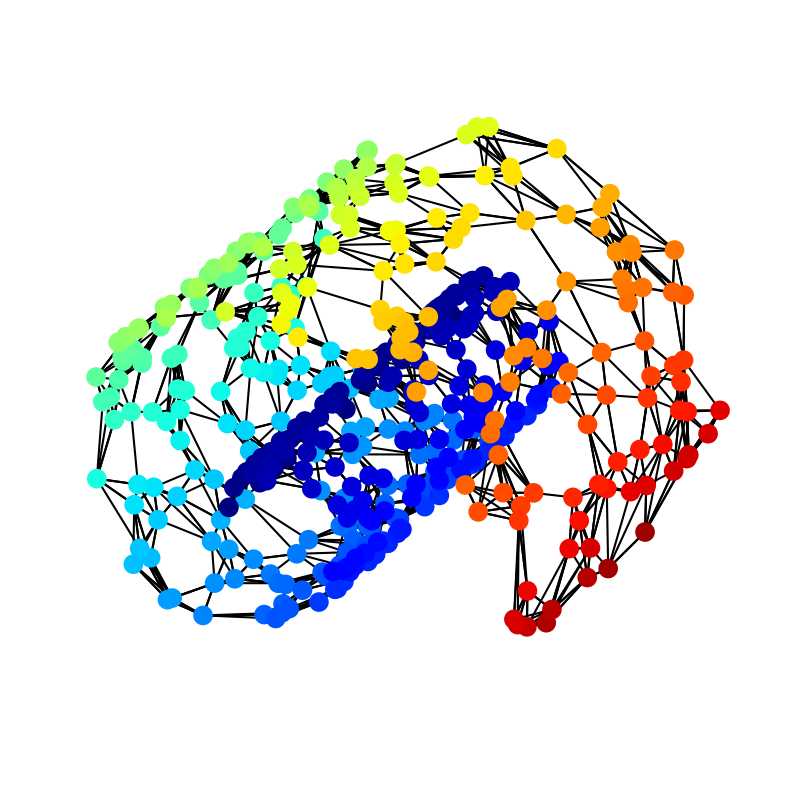

In [8]:
# 将 X 格式化为 (n_samples, n_features)
X = np.transpose(X)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

# 绘制原始瑞士卷
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=plt.cm.jet((X[:, 0]**2 + X[:, 2]**2) / 100), s=200, lw=0, alpha=1)

# 循环遍历每个数据点并绘制连接最近邻的线条
k = 6  # 最近邻数量
knn = nearest_neighbors(X, k)  # 使用自定义函数找到每个数据点的最近邻
# 遍历所有数据点
for i in range(len(X)):
    neighbors = knn[i]  # 找到当前数据点的最近邻索引
    # 遍历最近邻索引列表
    for j in range(len(neighbors)):
        # 绘制当前数据点与其最近邻之间的连线，根据三维坐标绘制线条
        ax.plot(X[[i, neighbors.astype('int')[j]], 0], 
                X[[i, neighbors.astype('int')[j]], 1], 
                X[[i, neighbors.astype('int')[j]], 2], color='black')

# 配置坐标轴设置
ax.axis("off")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.set_zlim(np.min(X[:, 2]), np.max(X[:, 2]))
plt.show();

这里绘制了连接每个点与其k个最近邻的边，以展示这个图如何形成底层流形的离散模型。现在，距离是沿着图的路径进行测量的，从视觉上可以清楚地看出这是学习流形基本结构的更好方法。现在我们使用`sklearn.manifold`中的isomap实现并可视化低维配置。 

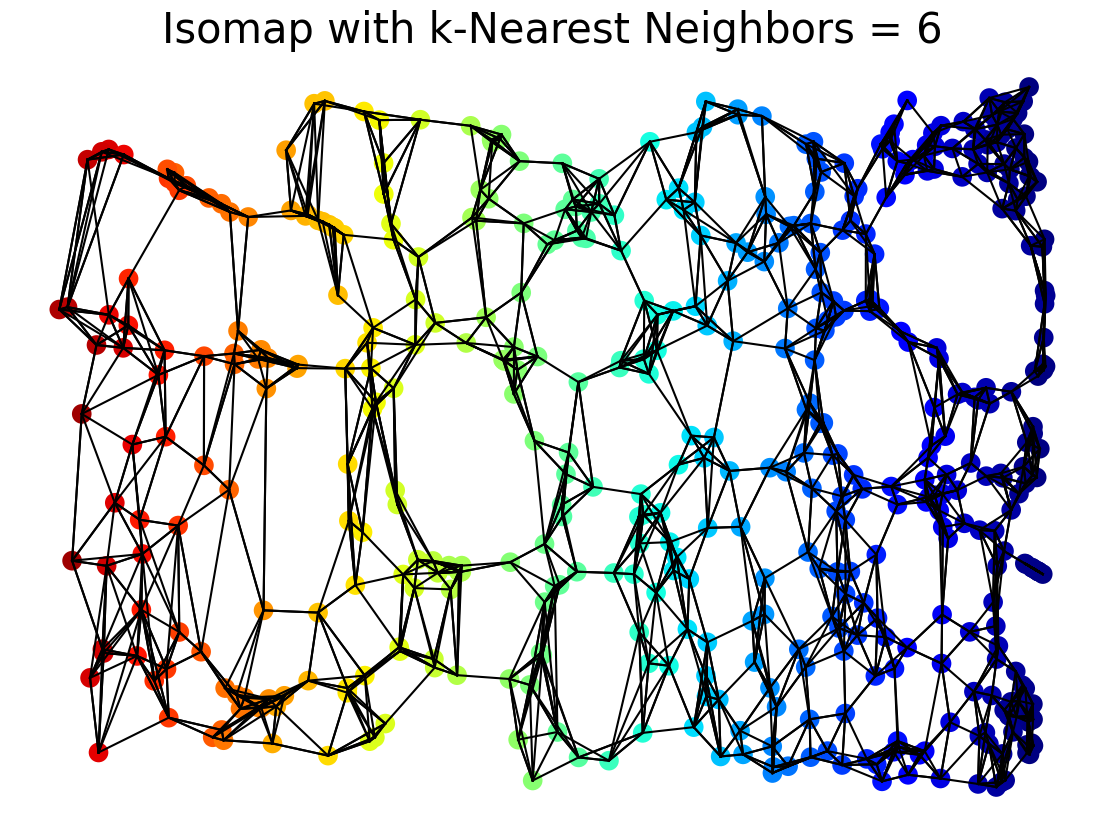

In [9]:
# 自定义 Dijkstra 算法实现，用于计算最短路径
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]
    visited = np.zeros(n, dtype=bool)
    distances = np.full(n, np.inf)
    distances[start] = 0

    for _ in range(n):
        current = -1
        min_distance = np.inf

        # 找到当前节点中距离起始节点最近的未访问节点
        for i in range(n):
            if not visited[i] and distances[i] < min_distance:
                current = i
                min_distance = distances[i]

        if current == -1:
            break

        visited[current] = True
        # 更新与当前节点相邻的节点的距离
        for neighbor in range(n):
            if not visited[neighbor] and graph[current, neighbor] > 0:
                new_distance = distances[current] + graph[current, neighbor]
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
    return distances

# 自定义 MDS 算法实现
def classical_mds(distances, n_components):
    n = distances.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J.dot(distances ** 2).dot(J)
    eigenvalues, eigenvectors = np.linalg.eigh(B)

    # 对特征值和特征向量进行排序
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # 选择前 n_components 个特征值和对应的特征向量
    eigenvalues = eigenvalues[:n_components]
    eigenvectors = eigenvectors[:, :n_components]

    # 计算降维后的结果
    embeddings = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))
    return embeddings

# 执行 Isomap 算法
def isomap(X, n_neighbors, n_components):
    # Step 1: 计算欧几里得距离的成对距离矩阵
    dist_matrix = pairwise_distances(X)
    
    # Step 2: 构建 k-最近邻图的距离矩阵
    knn_matrix = np.zeros((len(X), n_neighbors))
    for i in range(len(X)):
        knn_matrix[i] = np.argsort(dist_matrix[i])[1:n_neighbors+1]

    # Step 3: 构建 k-最近邻图的邻接矩阵
    adjacency_matrix = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in knn_matrix[i]:
            adjacency_matrix[i][int(j)] = dist_matrix[i][int(j)]
            adjacency_matrix[int(j)][i] = dist_matrix[int(j)][i]

    # Step 4: 使用 Dijkstra 算法计算最短路径
    shortest_paths = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        shortest_paths[i] = dijkstra_shortest_path(adjacency_matrix, i)

    # Step 5: 应用 MDS 算法获取低维嵌入结果
    embeddings = classical_mds(shortest_paths, n_components)
    
    return embeddings

# 设置参数
n_neighbors = 6
n_components = 2
data = X  # 数据

# 执行 Isomap 算法
isomap_embeddings = isomap(data, n_neighbors, n_components)

# 绘制 Isomap 投影结果
plt.figure(figsize=(14, 10))
plt.scatter(isomap_embeddings[:, 0], isomap_embeddings[:, 1], 
            c=plt.cm.jet((data[:,0]**2 + data[:,2]**2) / 100), s=200, lw=0, alpha=1)

# 绘制连接原始数据中同一邻近点的线条
for i in range(len(data)):
    neighbors = knn[i]
    for j in range(len(neighbors)):
        plt.plot(isomap_embeddings[[i, neighbors.astype('int')[j]], 0], 
                 isomap_embeddings[[i, neighbors.astype('int')[j]], 1], color='black')
        
plt.title('Isomap with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show();

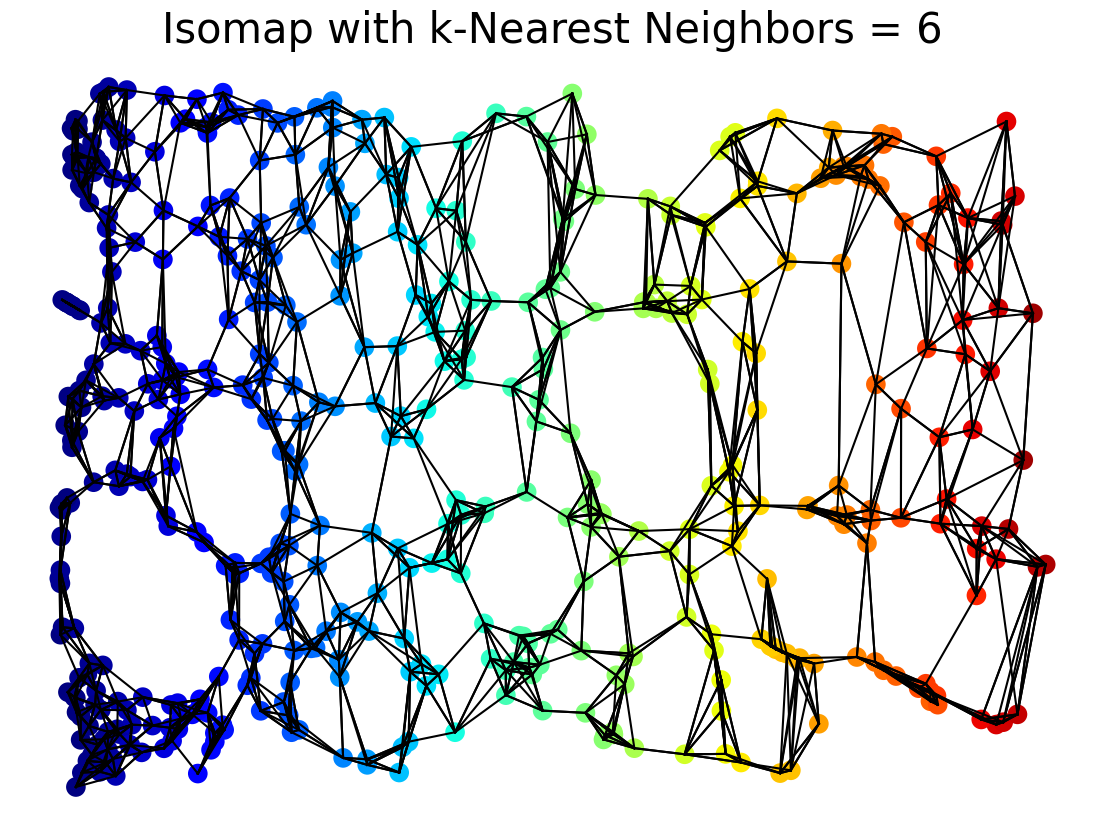

In [10]:
from sklearn.manifold import Isomap
data = X

# apply isomap with k = 6 and output dimension = 2
model = Isomap(n_components=2, n_neighbors=6)
proj = model.fit_transform(data)

# plot the isomap projection
plt.figure(figsize=(14,10))
plt.scatter(proj[:, 0], proj[:, 1], c=plt.cm.jet((X[:,0]**2+X[:,2]**2)/100), s=200, lw=0, alpha=1)

# plot lines connecting the same neighboring points from our original data
for i in range(len(X)):
    neighbors = knn[i]
    for j in range(len(neighbors)):
        plt.plot(proj[[i, neighbors.astype('int')[j]], 0], 
                 proj[[i, neighbors.astype('int')[j]], 1], color='black');
        
plt.title('Isomap with k-Nearest Neighbors = ' + str(k), size=30)
plt.axis("off")
plt.show();

Isomap能够学习非线性结构，并生成一个二维嵌入，展开了瑞士卷数据集，并很好地保留了成对的相似性和潜在结构。

### <font color='blue'> Example - Facial Images</font>

现在我们转向高维数据中最常见的来源之一 - 图像。我们使用`sklearn.datasets`导入数据，并选择每个人30张图像，共约80个不同的主题，其中标签代表图像识别的每个目标。

In [11]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

(2370, 2914)

(2370, 62, 47)

array(['Alejandro Toledo', 'Alvaro Uribe', 'Andre Agassi', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Colin Powell', 'David Beckham',
       'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Guillermo Coria', 'Hans Blix',
       'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien',
       'Jennifer Capriati', 'John Ashcroft', 'John Negroponte',
       'Junichiro Koizumi', 'Kofi Annan', 'Laura Bush', 'Lleyton Hewitt',
       'Luiz Inacio Lula da Silva', 'Megawati Sukarnoputri',
       'Nestor Kirchner', 'Recep Tayyip Erdogan', 'Roh Moo-hyun',
       'Serena Williams', 'Silvio Berlusconi', 'Tom Ridge', 'Tony Blair',
       'Vicente Fox', 'Vladimir Putin'], dtype='<U25')

array([ 8,  4, 21, ...,  8, 10,  8], dtype=int64)

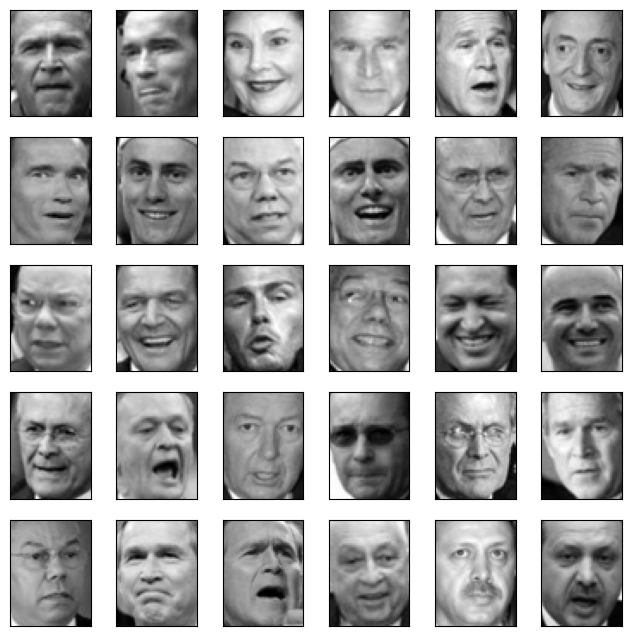

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape
faces.images.shape
faces.target_names
faces.target

# plot some images
fig, ax = plt.subplots(5, 6, subplot_kw=dict(xticks=[], yticks=[]), figsize=(8,8))
for i, axi in enumerate(ax.flat):
    _ = axi.imshow(faces.data[i].reshape(62, 47), cmap='gray');

每个数据点都是一幅图像，具有 $62 \times 47 = 2914$ 个特征，这些特征可以表示像素强度。我们选择一个特定主题的所有图像，看看Isomap是否能够有意义地降低图像数据的非常高的维度。

In [13]:
# define a function to plot small images over the data points
from matplotlib import offsetbox

# source: https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

'George W Bush'

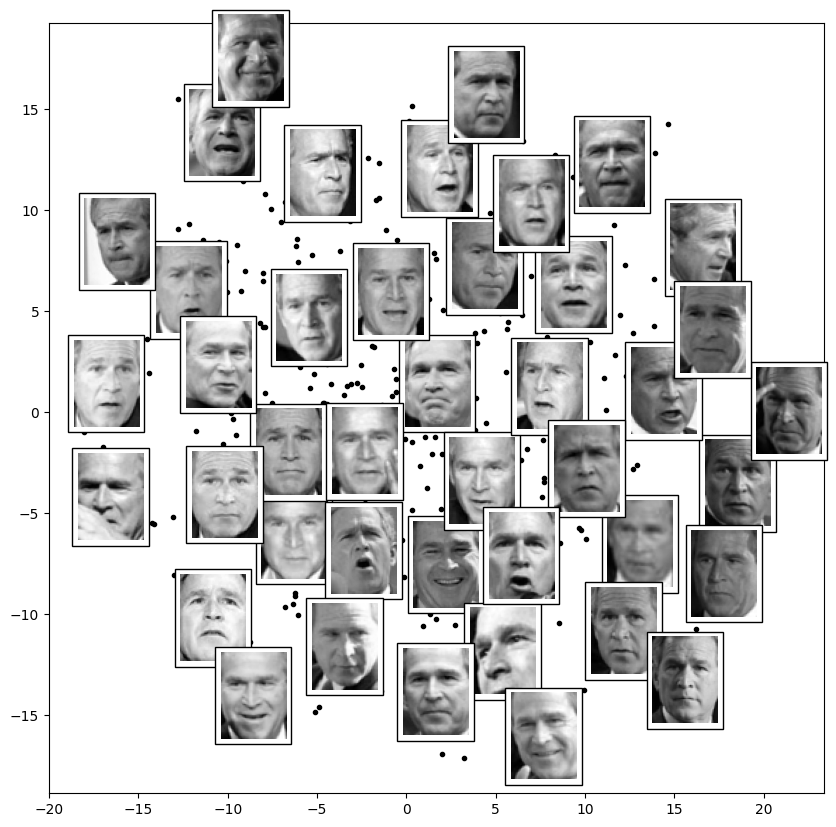

In [14]:
from sklearn.manifold import Isomap
np.random.seed(8888)
fig, ax = plt.subplots(figsize=(10, 10))
data = faces.data[faces.target==8]
images = faces.images[faces.target==8]
faces.target_names[8]
plot_components(data, model=Isomap(n_components=2, n_neighbors=8), images=images, thumb_frac=0.1)

从结果来看，Isomap在保持一些高维关系方面做得相当不错，可以看到图像在平面上移动时通常会变暗并改变摄像机角度。每个人只有30张图像，因此在不同主题之间，Isomap的性能会有很大差异。

### <font color='blue'> Example - Object Recognition</font>

现在我们探索另一个图像数据集，这次是包含100个随机对象图像的coil-100数据集。我们为每个对象导入一个样本图像，并应用Isomap算法来揭示二维表示。

In [15]:
import os
import matplotlib.image as img
from skimage.color import rgb2gray
os.getcwd()

def get_sample(path):
    ix = [int(i) for i in np.arange(0, len(os.listdir(path)), 72)]
    object_files = [os.listdir(path)[i] for i in (ix)]

    data = []
    for file in object_files:
        data.append(rgb2gray(plt.imread(path + '/' + file)))
    data = np.array(data)
    images = data
    data = data.reshape(100, 128*128)
    return data, images

path = 'images/coil-100'
sample_data, sample_images = get_sample(path)
sample_data.shape
sample_images.shape

ModuleNotFoundError: No module named 'skimage'

In [ ]:
from sklearn.manifold import Isomap
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(figsize=(14, 11))
plot_components(sample_data,
                model=Isomap(n_components=2),
                images=sample_images[:, ::2, ::2],
                thumb_frac=0.07)

Isomap能够展示一些有趣的潜在结构，比如玩具车的聚类、咖啡杯和汽水罐图像之间的相似性，以及一些出人意料的模式，比如牙线和与卫生有关的产品的半聚类，这些都是Isomap显然能够发现的。以下是coil-100数据集上Isomap的几个示例。

In [ ]:
# read in all the images for a collection of objects
def get_objects(path, keys):
    obj_keys = ['obj' + str(key) + '__' for key in keys]
    data = []
    for obj_key in obj_keys:
        object_files = [x for x in os.listdir(path) if obj_key in x]
        for image in object_files:
            data.append(rgb2gray(plt.imread(path + '/' + image)))

    data = np.array(data)
    images = data
    data = data.reshape(len(keys)*72, 128*128)
    return data, images

In [ ]:
# select a set of indices for object images
objects = np.arange(1, 90, 15)
object_data, object_images = get_objects(path, objects)
object_data.shape
object_images.shape

In [ ]:
fig, ax = plt.subplots(4, 4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(8,8))
for i, axi in enumerate(ax.flat):
    _ = axi.imshow(object_images[(i+1)*24 - 4], cmap='gray');

In [ ]:
from sklearn.manifold import Isomap
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(object_data, 
                model=Isomap(n_components=2, n_neighbors=15),
                images=object_images[:, ::2, ::2],
                thumb_frac=0.1)

在这里，物体清晰地被聚类，而流形学习在这种情况下尤其有用，因为存在明确的内在维度。每个物体的不同摄像机角度范围代表了数据的很大变化，而且由于这些物体似乎只有少数几个旋转自由度，因此这种固有的低维结构可以被分析。

___

### References


-  [1] _A Global Geometric Framework for Nonlinear Dimensionality Reduction,_
J. B. Tenenbaum, V. de Silva and J. C. Langford,
Science 290 (5500): 2319-2323, 22 December 2000. https://web.mit.edu/cocosci/Papers/sci_reprint.pdf
-  [2] https://en.wikipedia.org/wiki/Centering_matrix
-  [3] Wickelmaier, Florian. "An introduction to MDS." Sound Quality Research Unit, Aalborg University, Denmark (2003)